<a href="https://colab.research.google.com/github/QidiLiu/ML_notebook/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 手写数字图片的分类 - Classification

In [1]:
# 引入手写图像数据库
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

数据库结构：70000个图像和对应的70000个标签

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


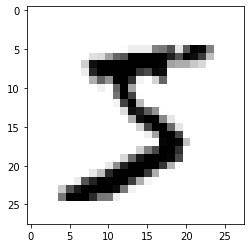

5


In [3]:
# 随便一看
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.show()

print(y[0])

In [0]:
import numpy as np

# 把标签格式由String转为Integer
y = y.astype(np.uint8)

# MNIST中前六万个是train set，后一万个是test set.所以可以直接分，不用考虑怎么分
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
# 搞一个"是否"分类器（此处判断目标：是不是5）
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5) # 把标签转为布尔值

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
# 随便预测一下
sgd_clf.predict([some_digit])

array([ True])

这是最入门的一种分类器，判断图片数字是否为5。上一行的输出表明预测值与实际值相同。

但这只是个入门，在这次训练和预测过程中，数据集本身就被调节到适合训练的样子，预测也很随便，一切设定都是为了读者能更简单的把握“分类器”的核心概念。

在性能评估方面，分类器比回归器更棘手一些。

In [7]:
# Measuring Accuracy Using Cross-Validation
# 这段代码其实是Scikit-learn的cross_val_score()的核心算法，只供理解，没必要这么麻烦
from sklearn.model_selection import StratifiedKFold
from sklearn import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42) # n_splits:分成3份，其中两份做样本，剩下一份做测试：random_state:洗牌的种子

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf) # 克隆已训练好的二元分类器
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  n_correct = sum(y_pred == y_test_folds)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


此处Cross-Validation的算法逻辑是先把数据集分为样本和标签的训练层和测试层，再用训练层训练模型，最后用测试层计算准确度。为啥不用之前分好的train set和test set呢，因为**要把test set留到最后用**。

来自[sklearn包中StratifiedKFold和KFold生成交叉验证数据集的区别](https://blog.csdn.net/MsSpark/article/details/84455402)：
- KFold交叉采样：将训练/测试数据集划分n_splits个互斥子集，每次只用其中一个子集当做测试集，剩下的（n_splits-1）作为训练集，进行n_splits次实验并得到n_splits个结果。
- StratifiedKFold分层采样，用于交叉验证：与KFold最大的差异在于，StratifiedKFold方法是根据标签中不同类别占比来进行拆分数据的。
- 两种采样器对象的各参数：
  - n_splits：表示将数据划分几等份
  - shuffle：在每次划分时，是否进行洗牌
    - 若为False，其效果相当于random_state为整数(含零)，每次划分的结果相同
    - 若为True，每次划分的结果不一样，表示经过洗牌，随机取样的
  - random_state：随机种子数，当设定值(一般为0)后可方便调参，因为每次生成的数据集相同

In [8]:
# sklearn库内集成的Cross-Validation算法
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

预测准确率不适合作为分类器的评价标准。如果我们做一个Not-5-classifier，这个分类器不做任何计算不管输入什么都是输出True（也就是说，这个分类器分类全靠蒙），那么在一个5很少的测试集里（比如这个0-9均匀分布的手写数字集），这个分类器的准确率可高达90%，略低于上面用的SGDClassifier（随机梯度下降模型）。

所以要引入**Confusion Matrix（[混淆矩阵](https://zh.wikipedia.org/wiki/%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%98%B5)）**。

混淆矩阵的核心是把预测结果的错误部分细分为**误判——False Negative(FN)**和**漏判——False Positive(FP)**。

类似的，还有**真正例（TP）**和**真反例（TN）**。

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # 本方法返回测试层的预测结果集

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

为了深入应用混淆矩阵的这四部分，要引入**精准率(precision)**和**召回率(recall)**，以及**F1值**。【[本段来源：机器之心](https://www.jiqizhixin.com/articles/2019-03-07-12)】

**精准率(precision)**：预测为正例的样本中，有多少是真的正例。$$precision=\frac{TP}{TP+FP}$$

**召回率(recall)**：真实的正例的样本中，有多少被预测出来。$$recall=\frac{TP}{TP+FN}$$

**F1值**：精准率和召回率的调和平均。$$\frac{1}{F_1}=\frac{1}{2}\left(\frac{1}{P}+\frac{1}{R}\right)$$$$F_1=\frac{2}{\frac{1}{P}+\frac{1}{R}}=2\times\frac{P\times R}{P+R}$$

直接用F1值比较分类器更方便，F1越大，说明分类器的综合性能更好。

In [10]:
# 在sklearn库里有现成的函数计算precision, recall 和 F1 Score.
from sklearn.metrics import precision_score, recall_score, f1_score
print(f'precision_score: {precision_score(y_train_5, y_train_pred)}')
print(f'recall_score: {recall_score(y_train_5, y_train_pred)}')
print(f'f1_score: {f1_score(y_train_5, y_train_pred)}')

precision_score: 0.8370879772350012
recall_score: 0.6511713705958311
f1_score: 0.7325171197343846


Precision和Recall详尽的分类器F1值高。这意味着，如果对你的目标而言Precision更重要或Recall更重要，F1值就不是个好的评价标准。

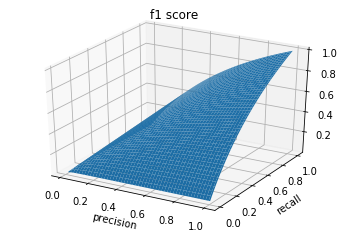

In [11]:
# Precision, Recall 和 F1值之间的关系
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')

any_precision = np.linspace(0.01, 1, 100)
any_recall = np.linspace(0.01, 1, 100)
any_precision, any_recall = np.meshgrid(any_precision, any_recall)

any_f1_score = 2*any_precision*any_recall/(any_precision+any_recall)

ax.plot_surface(any_precision, any_recall, any_f1_score)  #这里传入x, y, z的值

plt.xlabel('precision')
plt.ylabel('recall')
plt.title('f1 score')

plt.show()

如果你已经清楚了precision和recall的含义，完全可以跳过本单元格，直接看“阈值，精准率与召回率关系图”。

如果你看了上边的解释仍然没搞清precision和recall的含义，不要着急，这地方本来就是个难点，建议看看[吴恩达教授对这两个概念的解释](https://www.coursera.org/lecture/machine-learning/trading-off-precision-and-recall-CuONQ)，或者看看这篇[“通俗理解 Precision and Recall Trade-off”](http://wendingp.me/2017/0728/Understanding-Precision-and-Recall-Trade-off/)里举的例子。

为了更清楚地分辨这两个概念，我再打个比方：

想象你是《1984》中[真理部](https://zh.wikipedia.org/wiki/%E7%9C%9F%E7%90%86%E9%83%A8)的一名审核员，负责把待出版文章分类为“不符合核心价值观”的和“符合核心价值观”。不知为什么，最近你的同事挨个人间蒸发，分给你的工作量越来越大。于是你打算用机器学习训练一个文章分类器，以减轻分类压力。可[自然语言处理（NLP）](https://zh.wikipedia.org/wiki/%E8%87%AA%E7%84%B6%E8%AF%AD%E8%A8%80%E5%A4%84%E7%90%86)毕竟还有很长的路要走，你的分类器总会有疏漏。为了不被“蒸发”，你必须仔细测试分类器的性能。

假设这个分类器的分类依据是模型算出来的文章“不符合核心价值观”的可能性p，当p大于阈值t时为True，反之为False，那么这个阈值将直接影响TP, TN, FP, FN的大小，进而影响precision和recall的大小。那么阈值t设为多少合适呢？

再看一下它们的概念：
- **精准率(precision)**：预测为正例的样本中，有多少是真的正例。$$precision=\frac{TP}{TP+FP}$$
- **召回率(recall)**：真实的正例的样本中，有多少被预测出来。$$recall=\frac{TP}{TP+FN}$$

仔细考虑一下你的任务，这两个值对你的工作有什么具体的影响呢？**精准率(precision)**很高意味着，在分类器标定的“叛党言论”中有很高的比例的确是“叛党言论”。而**召回率(recall)**很高意味着，在分类器“放过”的文章中只有很小的一部分是“漏网之鱼”，或者说是需要“召回”的，从这个角度看，把这个值叫做“**不需召回**”可能更容易理解。

一般而言，若提高阈值t，TP会随之减小，FP减少，FN增大，于是**精准率(precision)**增大。$$t↑→\frac{TP↓}{TP↓+FP↓}→precision↑$$

反之，若降低阈值t，TP会随之增大，FP增大，FN减少，于是**召回率(recall)**增大。$$t↓→\frac{TP↑}{TP↑+FN↓}→recall↑$$

本着“宁可错杀三千，不可放走一人”的精神，**召回率(recall)**对“真理部审核”这样的任务更重要，因为精准率过低意味着文章的写作群体多几个冤魂，而如果**精准率(precision)**过低你就离被“蒸发”不远了。

下面我们用图像再看一下阈值大小对精准率和召回率的影响。

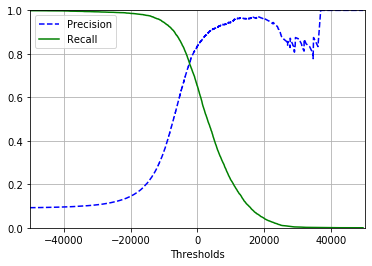

In [12]:
# 阈值，精准率与召回率关系图
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.xlim(-50000, 50000)
  plt.ylim(0, 1)
  plt.xlabel("Thresholds")
  plt.grid()
  plt.legend()

'''
  # 坐标轴投影(有bug,暂时取消)
  thr_0 = 8000
  pre_0 = precisions[thr_0]
  print(precisions[8000])
  rec_0 = recalls[thr_0]
  print(recalls[8000])
  plt.plot([thr_0, thr_0,], [0, pre_0,], 'r--')
  plt.plot([-50000, thr_0,], [pre_0, pre_0,], 'r--')
  plt.scatter([thr_0, ], [pre_0, ], s=50, color='r')
  plt.plot([thr_0, thr_0,], [0, rec_0,], 'r--')
  plt.plot([-50000, thr_0,], [rec_0, rec_0,], 'r--')
  plt.scatter([thr_0, ], [rec_0, ], s=50, color='r')
'''

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()